# 🔬 O-ISAC PRISMA Extraction Pipeline v2.0

Bu notebook, PRISMA Protocol Section 9 ile tam uyumlu veri çıkarma işlemini gerçekleştirir.

## 📋 Gereksinimler
- Google Drive erişimi
- Groq API Key ([groq.com](https://groq.com) üzerinden ücretsiz alınabilir)

---

## 1️⃣ Kurulum

In [4]:
# Google Drive'ı bağla
from google.colab import drive
drive.mount('/content/drive')
print('✅ Drive bağlandı!')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Drive bağlandı!


In [5]:
# Gerekli kütüphaneleri yükle
!pip install openai -q
print('✅ Kütüphaneler yüklendi!')

✅ Kütüphaneler yüklendi!


In [6]:
# API Key'i kaydet (Secrets bölümünden)
# Sol menüden 🔑 simgesine tıkla > "Add a new secret" >
# Name: GROQ_API_KEY, Value: gsk_xxxxxxxx

from google.colab import userdata
try:
    api_key = userdata.get('GROQ_API_KEY')
    print(f'✅ API Key bulundu: {api_key[:10]}...')
except:
    print('❌ HATA: Sol menüden 🔑 Secrets bölümüne GROQ_API_KEY ekleyin!')

✅ API Key bulundu: gsk_XXClFQ...


## 2️⃣ Konfigürasyon

In [7]:
import asyncio
import os
import glob
import json
import pandas as pd
from datetime import datetime
from openai import AsyncOpenAI
from google.colab import userdata

# =============================================================================
# PROJE YOLLARI - Kendi Drive yapınıza göre düzenleyin
# =============================================================================
PROJECT_PATH = "/content/drive/MyDrive/AKU_WorkSpace/survey_fdgit/OISAC_PRISMA_COMST"
INTERMEDIATE_DIR = os.path.join(PROJECT_PATH, "data/processed_markdowns")
FINAL_DIR = os.path.join(PROJECT_PATH, "data/extraction_results_v2")

# Çıktı klasörünü oluştur
os.makedirs(FINAL_DIR, exist_ok=True)

# API Bağlantısı
client = AsyncOpenAI(
    api_key=userdata.get('GROQ_API_KEY'),
    base_url="https://api.groq.com/openai/v1"
)

print(f"📁 Proje dizini: {PROJECT_PATH}")
print(f"📄 Markdown dizini: {INTERMEDIATE_DIR}")
print(f"📊 Çıktı dizini: {FINAL_DIR}")
print("✅ Konfigürasyon tamamlandı!")

📁 Proje dizini: /content/drive/MyDrive/AKU_WorkSpace/survey_fdgit/OISAC_PRISMA_COMST
📄 Markdown dizini: /content/drive/MyDrive/AKU_WorkSpace/survey_fdgit/OISAC_PRISMA_COMST/data/processed_markdowns
📊 Çıktı dizini: /content/drive/MyDrive/AKU_WorkSpace/survey_fdgit/OISAC_PRISMA_COMST/data/extraction_results_v2
✅ Konfigürasyon tamamlandı!


In [8]:
# Mevcut makaleleri kontrol et
folders = sorted([f for f in glob.glob(os.path.join(INTERMEDIATE_DIR, "*")) if os.path.isdir(f)])
print(f"📚 Toplam {len(folders)} makale bulundu:\n")
for f in folders:
    paper_id = os.path.basename(f)
    md_files = glob.glob(os.path.join(f, "*.md"))
    vis_file = os.path.exists(os.path.join(f, "visual_analysis.txt"))
    print(f"  • {paper_id}: MD={'✅' if md_files else '❌'}, Visual={'✅' if vis_file else '❌'}")

📚 Toplam 10 makale bulundu:

  • O_ISAC_001: MD=✅, Visual=✅
  • O_ISAC_002: MD=✅, Visual=✅
  • O_ISAC_003: MD=✅, Visual=✅
  • O_ISAC_004: MD=✅, Visual=✅
  • O_ISAC_005: MD=✅, Visual=✅
  • O_ISAC_006: MD=✅, Visual=✅
  • O_ISAC_007: MD=✅, Visual=✅
  • O_ISAC_008: MD=✅, Visual=✅
  • O_ISAC_009: MD=❌, Visual=❌
  • O_ISAC_010: MD=✅, Visual=✅


## 3️⃣ System Prompt (PRISMA Protocol Section 9)

In [9]:
SYSTEM_PROMPT = """
You are a Senior Technical Editor for IEEE COMST and an advanced extraction engine for a PRISMA-2020-compliant systematic review on "Optical Integrated Sensing and Communication (O-ISAC)".

Your task is to extract STRUCTURED DATA from academic papers into a precise JSON format. You must be thorough and extract ALL reported metrics.

================================================================================
CRITICAL RULES
================================================================================
1. ONLY extract explicitly stated values. Use "NR" (Not Reported) for missing data.
2. Use "NA" (Not Applicable) when a field doesn't apply to this paper type.
3. Create MULTIPLE experiment entries if the paper reports different scenarios.
4. Include EVIDENCE snippets (exact quotes) for all numerical values.
5. Pay attention to UNITS - convert to standard units specified in the schema.
6. The "isac_waveform_relationship" field is CRITICAL - determine how S&C waveforms relate.

================================================================================
OUTPUT JSON STRUCTURE
================================================================================
{
  "Paper_ID": "O_ISAC_XXX",

  "Study_Level": {
    "title": "string",
    "year": integer,
    "venue": "string",
    "document_type": "journal" | "conference" | "letter" | "review",

    "oisac_medium_class": "cabled_fibre" | "wireless_fso" | "wireless_vlc" | "wireless_lidar_like" | "wireless_retroreflective" | "hybrid",
    "carrier_band": "visible" | "NIR" | "C-band" | "L-band" | "other" | "NR",
    "operational_environment": "indoor" | "outdoor" | "lab" | "field_trial" | "mixed" | "NR",
    "link_topology": "monostatic" | "bistatic" | "multistatic" | "distributed_fibre" | "point_to_point" | "NR",

    "application_domain": ["vehicular", "indoor_positioning", "fibre_network_monitoring", ...],
    "evidence_type": ["simulation", "experimental", "analytical", "hybrid"],

    "ris_present": boolean,
    "opa_present": boolean,
    "ml_used": boolean,

    "key_contribution": "1-2 sentence summary",
    "gap_addressed": "1 sentence"
  },

  "Experiments": [
    {
      "Experiment_ID": "E1",
      "Scenario_Label": "Descriptive label (e.g., 'FSO link, 1km, Gamma-Gamma turbulence')",

      "Transmitter": {
        "tx_source_type": "laser" | "led" | "vcsel" | "frequency_comb" | "other",
        "tx_modulation_type": "im_dd" | "coherent" | "mixed" | "NR",
        "wavelength_nm": float or null,
        "tx_power_dbm": float or null,
        "optical_bandwidth_ghz": float or null
      },

      "Receiver": {
        "rx_detection_type": "direct" | "coherent" | "self_coherent" | "imaging" | "spad",
        "rx_detector": "pin_pd" | "apd_pd" | "balanced_pd" | "camera" | "NR"
      },

      "Integration": {
        "hardware_sharing_mode": "shared_frontend" | "partially_shared" | "separate_frontends" | "NR",
        "duplexing_mode": "full_duplex" | "half_duplex" | "tdm" | "fdm" | "wdm" | "NR"
      },

      "Waveform": {
        "comm_waveform_family": "ook" | "pam" | "ofdm" | "dmt" | "qam" | "psk" | "chirp_fmcw" | "other",
        "comm_modulation_order": integer or null,
        "comm_symbol_rate_gbaud": float or null,
        "sensing_waveform_family": "pulse_tof" | "fmcw_chirp" | "lfm_chirp" | "ofdm_sensing" | "backscatter_probe" | "same_as_comm" | "other",
        "isac_waveform_relationship": "single_dual_function" | "comm_embedded_in_sensing" | "sensing_embedded_in_comm" | "multiplexed_separate" | "superimposed" | "NR",
        "resource_partition": "string describing split (e.g., 'α=0.7 power to comm') or null"
      },

      "Channel_Fiber": {
        "fibre_length_km": float or null,
        "fibre_type": "smf" | "mmf" | "fmf" | "mcf" | null,
        "attenuation_db_per_km": float or null,
        "backscatter_sensing_type": "rayleigh_phi_otdr" | "das" | "brillouin" | "raman" | null
      },

      "Channel_Wireless": {
        "link_distance_m": float or null,
        "turbulence_model": "lognormal" | "gamma_gamma" | "malaga" | "none" | null,
        "turbulence_Cn2": float or null,
        "pointing_error_model": "zero" | "gaussian_jitter" | "beckmann" | null,
        "weather_visibility_m": float or null
      },

      "Comm_Metrics": {
        "data_rate_gbps": float or null,
        "spectral_efficiency_bps_hz": float or null,
        "ber": float or null,
        "snr_db": float or null,
        "outage_probability": float or null,
        "latency_ms": float or null
      },

      "Sensing_Metrics": {
        "sensing_task_type": ["ranging", "velocity", "localization_2d", "vibration", "target_detection", ...],
        "sensing_range_m": float or null,
        "range_resolution_m": float or null,
        "range_accuracy_m": float or null,
        "velocity_resolution_mps": float or null,
        "localization_error_m": float or null,
        "pd_detection_prob": float or null,
        "pfa_false_alarm": float or null,
        "crb_crlb_value": float or null,
        "crb_parameter": "range" | "angle" | "delay" | "position" | null
      },

      "Tradeoff": {
        "coupling_mode": "resource_division" | "joint_waveform" | "joint_receiver_processing" | "shared_hardware_only" | "NR",
        "tradeoff_type": ["rate_vs_rmse", "rate_vs_range_resolution", "power_split", "time_split", ...] or [],
        "tradeoff_representation": "single_point" | "curve" | "pareto_front" | "table" | "not_explicit",
        "tradeoff_control_parameter": "string (e.g., 'α', 'power_ratio')" or null,
        "tradeoff_control_range": "string (e.g., '[0.1, 0.9]')" or null
      },

      "OPA_Details": {
        "opa_num_emitters": integer or null,
        "opa_steering_range_deg": float or null
      },

      "Evidence": [
        {"field": "data_rate_gbps", "snippet": "exact quote from paper", "source": "TEXT" | "TABLE" | "FIGURE"},
        {"field": "range_resolution_m", "snippet": "exact quote", "source": "TEXT"},
        {"field": "isac_waveform_relationship", "snippet": "quote explaining waveform design", "source": "TEXT"}
      ],

      "Source_Pointer": "e.g., 'Section IV, Table II, Fig. 5'"
    }
  ],

  "Quality_Flags": {
    "both_sc_metrics_reported": boolean,
    "tradeoff_explicitly_analyzed": boolean,
    "uncertainty_reported": boolean,
    "baseline_comparison_present": boolean
  }
}

================================================================================
IMPORTANT NOTES
================================================================================
- For wavelength: Convert to nm (e.g., 1.55 μm → 1550 nm)
- For data rate: Convert to Gbps (e.g., 100 Mbps → 0.1 Gbps, 1 Tbps → 1000 Gbps)
- For distance: Convert to meters for wireless, km for fiber
- The "isac_waveform_relationship" is CRITICAL for taxonomy - always try to determine it
- If paper does NOT report BOTH comm AND sensing metrics, flag it in Quality_Flags
"""

print("✅ System prompt yüklendi!")
print(f"   Prompt uzunluğu: {len(SYSTEM_PROMPT)} karakter")

✅ System prompt yüklendi!
   Prompt uzunluğu: 6925 karakter


## 4️⃣ Extraction Fonksiyonları

In [10]:
async def extract_paper_v2(folder_path, semaphore):
    """Tek bir makaleden veri çıkar."""
    async with semaphore:
        paper_id = os.path.basename(folder_path)

        # O_ISAC_007'yi atla (excluded)
        if paper_id == "O_ISAC_007":
            print(f"   ⏭️ Atlanan: {paper_id} (excluded - pure sensing)")
            return None

        # Markdown dosyasını bul
        md_files = glob.glob(os.path.join(folder_path, "*.md"))
        vis_file = os.path.join(folder_path, "visual_analysis.txt")

        if not md_files:
            print(f"   ⚠️ Markdown bulunamadı: {paper_id}")
            return None

        try:
            # İçeriği oku
            with open(md_files[0], "r", encoding="utf-8") as f:
                text = f.read()

            visuals = ""
            if os.path.exists(vis_file):
                with open(vis_file, "r", encoding="utf-8") as f:
                    visuals = f.read()

            # Prompt oluştur
            user_content = f"""
=== PAPER ID: {paper_id} ===

=== VISUAL DATA (Charts/Figures) ===
{visuals if visuals else "No visual data extracted."}

=== FULL PAPER TEXT ===
{text[:90000]}
"""

            print(f"   🔬 Çıkarılıyor: {paper_id}...")

            response = await client.chat.completions.create(
                model="llama-3.3-70b-versatile",
                messages=[
                    {"role": "system", "content": SYSTEM_PROMPT},
                    {"role": "user", "content": user_content}
                ],
                response_format={"type": "json_object"},
                temperature=0.05,
                max_tokens=8000
            )

            result = json.loads(response.choices[0].message.content)
            result["Paper_ID"] = paper_id
            result["extraction_timestamp"] = datetime.now().isoformat()
            result["schema_version"] = "2.0"

            exp_count = len(result.get('Experiments', []))
            print(f"   ✅ Tamamlandı: {paper_id} - {exp_count} deney")
            return result

        except Exception as e:
            print(f"   ❌ Hata ({paper_id}): {e}")
            return {"Paper_ID": paper_id, "error": str(e)}

print("✅ Extraction fonksiyonu tanımlandı!")

✅ Extraction fonksiyonu tanımlandı!


In [11]:
def flatten_study_level(data):
    """Study-level verileri CSV için düzleştir."""
    rows = []
    for paper in data:
        if "error" in paper:
            continue

        sl = paper.get("Study_Level", {})
        qf = paper.get("Quality_Flags", {})

        rows.append({
            "Paper_ID": paper.get("Paper_ID"),
            "Title": sl.get("title"),
            "Year": sl.get("year"),
            "Venue": sl.get("venue"),
            "Document_Type": sl.get("document_type"),
            "Medium_Class": sl.get("oisac_medium_class"),
            "Carrier_Band": sl.get("carrier_band"),
            "Environment": sl.get("operational_environment"),
            "Topology": sl.get("link_topology"),
            "Application_Domains": "|".join(sl.get("application_domain", [])),
            "Evidence_Type": "|".join(sl.get("evidence_type", [])),
            "RIS_Present": sl.get("ris_present"),
            "OPA_Present": sl.get("opa_present"),
            "ML_Used": sl.get("ml_used"),
            "Key_Contribution": sl.get("key_contribution"),
            "Gap_Addressed": sl.get("gap_addressed"),
            "Both_SC_Metrics": qf.get("both_sc_metrics_reported"),
            "Tradeoff_Analyzed": qf.get("tradeoff_explicitly_analyzed"),
            "Uncertainty_Reported": qf.get("uncertainty_reported"),
            "Baseline_Present": qf.get("baseline_comparison_present")
        })
    return pd.DataFrame(rows)


def flatten_experiments(data):
    """Experiment-level verileri CSV için düzleştir."""
    rows = []
    for paper in data:
        if "error" in paper:
            continue

        paper_id = paper.get("Paper_ID")

        for exp in paper.get("Experiments", []):
            tx = exp.get("Transmitter", {})
            rx = exp.get("Receiver", {})
            intg = exp.get("Integration", {})
            wf = exp.get("Waveform", {})
            cf = exp.get("Channel_Fiber", {})
            cw = exp.get("Channel_Wireless", {})
            cm = exp.get("Comm_Metrics", {})
            sm = exp.get("Sensing_Metrics", {})
            tf = exp.get("Tradeoff", {})
            opa = exp.get("OPA_Details", {})

            rows.append({
                # Identification
                "Paper_ID": paper_id,
                "Exp_ID": exp.get("Experiment_ID"),
                "Scenario": exp.get("Scenario_Label"),
                "Source": exp.get("Source_Pointer"),

                # Transmitter
                "TX_Source": tx.get("tx_source_type"),
                "TX_Mod_Type": tx.get("tx_modulation_type"),
                "Wavelength_nm": tx.get("wavelength_nm"),
                "TX_Power_dBm": tx.get("tx_power_dbm"),
                "Optical_BW_GHz": tx.get("optical_bandwidth_ghz"),

                # Receiver
                "RX_Detection": rx.get("rx_detection_type"),
                "RX_Detector": rx.get("rx_detector"),

                # Integration
                "HW_Sharing": intg.get("hardware_sharing_mode"),
                "Duplexing": intg.get("duplexing_mode"),

                # Waveform - CRITICAL
                "Comm_Waveform": wf.get("comm_waveform_family"),
                "Mod_Order": wf.get("comm_modulation_order"),
                "Symbol_Rate_GBaud": wf.get("comm_symbol_rate_gbaud"),
                "Sensing_Waveform": wf.get("sensing_waveform_family"),
                "ISAC_Relationship": wf.get("isac_waveform_relationship"),
                "Resource_Partition": wf.get("resource_partition"),

                # Channel - Fiber
                "Fibre_Length_km": cf.get("fibre_length_km"),
                "Fibre_Type": cf.get("fibre_type"),
                "Attenuation_dB_km": cf.get("attenuation_db_per_km"),
                "Backscatter_Type": cf.get("backscatter_sensing_type"),

                # Channel - Wireless
                "Link_Distance_m": cw.get("link_distance_m"),
                "Turbulence_Model": cw.get("turbulence_model"),
                "Cn2": cw.get("turbulence_Cn2"),
                "Pointing_Error": cw.get("pointing_error_model"),
                "Visibility_m": cw.get("weather_visibility_m"),

                # Communication Metrics
                "Data_Rate_Gbps": cm.get("data_rate_gbps"),
                "Spectral_Eff_bps_Hz": cm.get("spectral_efficiency_bps_hz"),
                "BER": cm.get("ber"),
                "SNR_dB": cm.get("snr_db"),
                "Outage_Prob": cm.get("outage_probability"),
                "Latency_ms": cm.get("latency_ms"),

                # Sensing Metrics
                "Sensing_Tasks": "|".join(sm.get("sensing_task_type", [])) if isinstance(sm.get("sensing_task_type"), list) else sm.get("sensing_task_type", ""),
                "Sensing_Range_m": sm.get("sensing_range_m"),
                "Range_Resolution_m": sm.get("range_resolution_m"),
                "Range_Accuracy_m": sm.get("range_accuracy_m"),
                "Velocity_Resolution_mps": sm.get("velocity_resolution_mps"),
                "Localization_Error_m": sm.get("localization_error_m"),
                "Pd_Detection": sm.get("pd_detection_prob"),
                "Pfa_FalseAlarm": sm.get("pfa_false_alarm"),
                "CRB_Value": sm.get("crb_crlb_value"),
                "CRB_Param": sm.get("crb_parameter"),

                # Tradeoff - CRITICAL
                "Coupling_Mode": tf.get("coupling_mode"),
                "Tradeoff_Type": "|".join(tf.get("tradeoff_type", [])) if isinstance(tf.get("tradeoff_type"), list) else tf.get("tradeoff_type", ""),
                "Tradeoff_Repr": tf.get("tradeoff_representation"),
                "Tradeoff_Param": tf.get("tradeoff_control_parameter"),
                "Tradeoff_Range": tf.get("tradeoff_control_range"),

                # OPA
                "OPA_Emitters": opa.get("opa_num_emitters"),
                "OPA_Steering_deg": opa.get("opa_steering_range_deg")
            })

    return pd.DataFrame(rows)

print("✅ Flatten fonksiyonları tanımlandı!")

✅ Flatten fonksiyonları tanımlandı!


## 5️⃣ Ana Pipeline

In [12]:
async def run_extraction_pipeline_v2(limit=None):
    """Ana extraction pipeline."""

    print("\n" + "="*70)
    print("🚀 O-ISAC PRISMA EXTRACTION PIPELINE v2.0")
    print("="*70)

    # Makale klasörlerini bul
    folders = sorted([f for f in glob.glob(os.path.join(INTERMEDIATE_DIR, "*")) if os.path.isdir(f)])

    if limit:
        folders = folders[:limit]

    print(f"📄 İşlenecek makale: {len(folders)}")

    # Rate limit (Groq Free: 2 eşzamanlı)
    semaphore = asyncio.Semaphore(2)

    # Extraction
    print("\n📥 Extraction başlıyor...\n")
    tasks = [extract_paper_v2(f, semaphore) for f in folders]
    results = await asyncio.gather(*tasks)

    # Sonuçları filtrele
    valid_data = [r for r in results if r is not None]
    error_data = [r for r in valid_data if "error" in r]
    success_data = [r for r in valid_data if "error" not in r]

    print(f"\n✅ Başarılı: {len(success_data)}")
    print(f"❌ Hata: {len(error_data)}")

    if success_data:
        # JSON kaydet
        json_path = os.path.join(FINAL_DIR, "extraction_v2_full.json")
        with open(json_path, "w", encoding="utf-8") as f:
            json.dump(success_data, f, indent=2, ensure_ascii=False)

        # CSV'leri oluştur
        df_study = flatten_study_level(success_data)
        df_exp = flatten_experiments(success_data)

        study_path = os.path.join(FINAL_DIR, "study_level_v2.csv")
        exp_path = os.path.join(FINAL_DIR, "experiment_level_v2.csv")

        df_study.to_csv(study_path, index=False)
        df_exp.to_csv(exp_path, index=False)

        print("\n" + "="*70)
        print("📁 ÇIKTI DOSYALARI")
        print("="*70)
        print(f"📋 Full JSON: {json_path}")
        print(f"📊 Study-Level CSV: {study_path}")
        print(f"🔬 Experiment-Level CSV: {exp_path}")

        # İstatistikler
        print("\n" + "="*70)
        print("📈 HIZLI İSTATİSTİKLER")
        print("="*70)
        print(f"Toplam Deney: {len(df_exp)}")
        print(f"\nMedium Dağılımı:")
        print(df_study["Medium_Class"].value_counts().to_string())
        print(f"\nISAC Waveform Relationship:")
        print(df_exp["ISAC_Relationship"].value_counts().to_string())
        print(f"\nCoupling Mode:")
        print(df_exp["Coupling_Mode"].value_counts().to_string())

        # Örnek çıktı
        print("\n" + "="*70)
        print("🔍 ÖRNEK DENEY VERİSİ")
        print("="*70)
        display_cols = ["Paper_ID", "Scenario", "ISAC_Relationship", "Data_Rate_Gbps", "Range_Resolution_m", "Coupling_Mode"]
        print(df_exp[display_cols].head(5).to_string())

    return success_data

print("✅ Pipeline fonksiyonu tanımlandı!")

✅ Pipeline fonksiyonu tanımlandı!


## 6️⃣ Çalıştır! 🚀

In [13]:
# 🧪 PILOT TEST - Sadece 3 makale ile test et
results = await run_extraction_pipeline_v2(limit=3)


🚀 O-ISAC PRISMA EXTRACTION PIPELINE v2.0
📄 İşlenecek makale: 3

📥 Extraction başlıyor...

   🔬 Çıkarılıyor: O_ISAC_001...
   🔬 Çıkarılıyor: O_ISAC_002...
   ✅ Tamamlandı: O_ISAC_001 - 1 deney
   🔬 Çıkarılıyor: O_ISAC_003...
   ✅ Tamamlandı: O_ISAC_002 - 2 deney
   ✅ Tamamlandı: O_ISAC_003 - 2 deney

✅ Başarılı: 3
❌ Hata: 0

📁 ÇIKTI DOSYALARI
📋 Full JSON: /content/drive/MyDrive/AKU_WorkSpace/survey_fdgit/OISAC_PRISMA_COMST/data/extraction_results_v2/extraction_v2_full.json
📊 Study-Level CSV: /content/drive/MyDrive/AKU_WorkSpace/survey_fdgit/OISAC_PRISMA_COMST/data/extraction_results_v2/study_level_v2.csv
🔬 Experiment-Level CSV: /content/drive/MyDrive/AKU_WorkSpace/survey_fdgit/OISAC_PRISMA_COMST/data/extraction_results_v2/experiment_level_v2.csv

📈 HIZLI İSTATİSTİKLER
Toplam Deney: 5

Medium Dağılımı:
Medium_Class
wireless_vlc    2
hybrid          1

ISAC Waveform Relationship:
ISAC_Relationship
single_dual_function    3
NR                      2

Coupling Mode:
Coupling_Mode
resource_

In [14]:
# 🚀 TAM ÇALIŞMA - Tüm makaleleri işle (9 makale, O_ISAC_007 hariç)
# results = await run_extraction_pipeline_v2()

## 7️⃣ Sonuçları İncele

In [15]:
# Experiment-level CSV'yi yükle ve incele
df_exp = pd.read_csv(os.path.join(FINAL_DIR, "experiment_level_v2.csv"))
print(f"Toplam satır: {len(df_exp)}")
print(f"Toplam sütun: {len(df_exp.columns)}")
print("\nSütunlar:")
print(df_exp.columns.tolist())

Toplam satır: 5
Toplam sütun: 51

Sütunlar:
['Paper_ID', 'Exp_ID', 'Scenario', 'Source', 'TX_Source', 'TX_Mod_Type', 'Wavelength_nm', 'TX_Power_dBm', 'Optical_BW_GHz', 'RX_Detection', 'RX_Detector', 'HW_Sharing', 'Duplexing', 'Comm_Waveform', 'Mod_Order', 'Symbol_Rate_GBaud', 'Sensing_Waveform', 'ISAC_Relationship', 'Resource_Partition', 'Fibre_Length_km', 'Fibre_Type', 'Attenuation_dB_km', 'Backscatter_Type', 'Link_Distance_m', 'Turbulence_Model', 'Cn2', 'Pointing_Error', 'Visibility_m', 'Data_Rate_Gbps', 'Spectral_Eff_bps_Hz', 'BER', 'SNR_dB', 'Outage_Prob', 'Latency_ms', 'Sensing_Tasks', 'Sensing_Range_m', 'Range_Resolution_m', 'Range_Accuracy_m', 'Velocity_Resolution_mps', 'Localization_Error_m', 'Pd_Detection', 'Pfa_FalseAlarm', 'CRB_Value', 'CRB_Param', 'Coupling_Mode', 'Tradeoff_Type', 'Tradeoff_Repr', 'Tradeoff_Param', 'Tradeoff_Range', 'OPA_Emitters', 'OPA_Steering_deg']


In [16]:
# NR/null oranlarını kontrol et
null_pcts = df_exp.isnull().sum() / len(df_exp) * 100
print("📊 Boş Değer Oranları (%):\n")
print(null_pcts.sort_values(ascending=False).head(20).to_string())

📊 Boş Değer Oranları (%):

Tradeoff_Type              40.0
CRB_Param                  20.0
Resource_Partition         20.0
Visibility_m               20.0
Range_Resolution_m         20.0
Velocity_Resolution_mps    20.0
Range_Accuracy_m           20.0
Pfa_FalseAlarm             20.0
Pd_Detection               20.0
CRB_Value                  20.0
Localization_Error_m       20.0
Backscatter_Type           20.0
Outage_Prob                20.0
Latency_ms                 20.0
Cn2                        20.0
Fibre_Type                 20.0
Attenuation_dB_km          20.0
Fibre_Length_km            20.0
OPA_Emitters               20.0
OPA_Steering_deg           20.0


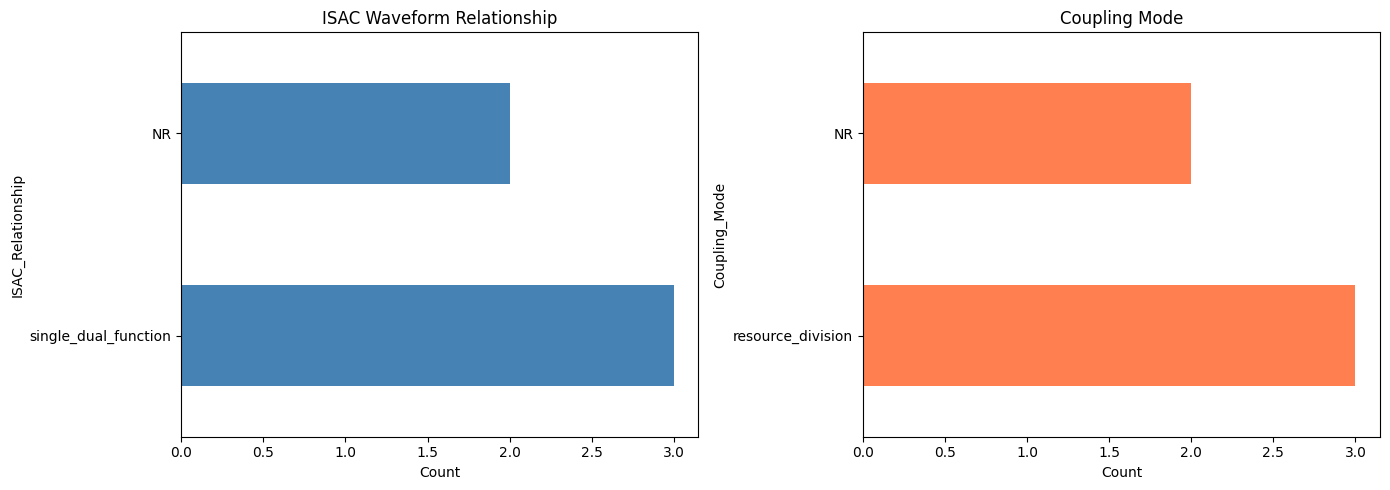

In [17]:
# ISAC Relationship dağılımı
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sol: ISAC Relationship
df_exp["ISAC_Relationship"].value_counts().plot(kind="barh", ax=axes[0], color="steelblue")
axes[0].set_title("ISAC Waveform Relationship")
axes[0].set_xlabel("Count")

# Sağ: Coupling Mode
df_exp["Coupling_Mode"].value_counts().plot(kind="barh", ax=axes[1], color="coral")
axes[1].set_title("Coupling Mode")
axes[1].set_xlabel("Count")

plt.tight_layout()
plt.show()